In [1]:
import os

import time
import torch
import numpy as np
from sklearn import datasets, model_selection, metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import falkon
assert torch.cuda.is_available()

In [2]:
from falkon import LogisticFalkon
from falkon.kernels import GaussianKernel
from falkon.options import FalkonOptions
from falkon.gsc_losses import WeightedCrossEntropyLoss

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# Statistics                                                                                                                                                   
N_REF      = 200000
N_BKG      = 2000
N_SIG      = 0      
SIG_LOC    = 6.4
SIG_STD    = 0.16
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# parameters
M = 2000
SIGMA = 0.5
PENALTY = 1e-10


In [5]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# the reference rate will not have nuisance parameters
feature_ref_dist = torch.distributions.Exponential(rate=1)
# the data rate will have nuisance parameters   
feature_bkg_dist = torch.distributions.Exponential(rate=1)
feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

print(f'bkg events = {N_bkg_p}; sig events = {N_sig_p}')


bkg events = 2033; sig events = 0


In [6]:
feature_ref  = feature_ref_dist.sample((N_REF,1))
feature_data = torch.cat(
    (
        feature_bkg_dist.sample((N_bkg_p, 1)),
        feature_sig_dist.sample((N_sig_p, 1))
    )
)

feature = torch.cat((feature_ref, feature_data), dim=0)

target_ref  = torch.zeros((N_REF, 1))
target_data = torch.ones((N_bkg_p + N_sig_p, 1))

target = torch.cat((target_ref, target_data), dim=0)


In [7]:
model_parameters = {
    'sigma' : 0.3, # kernel lengthscale
    'penalty_list' : [1e-10], # list of regularization parameters,
    'iter_list' : [20], #list of number of CG iterations,
    'M' : 3000, #number of Nystrom centers,
    'keops_active': "auto", # optional, if it is used, pyKeOPS is used to speed-up computations
    'seed' : 123456 # (int or None), the model seed (used for Nystrom center selection) is manually set.
 }

build model

In [8]:
kernel = GaussianKernel(torch.Tensor([model_parameters['sigma']]))
cg_tol = 1e-7
keops_active = "auto"
use_cpu = False
weight = N_BKG / N_REF

configuration = {
    'kernel' : kernel,
    'penalty_list' : model_parameters['penalty_list'],
    'iter_list' : model_parameters['iter_list'],
    'M' : model_parameters['M'],
    'options' : FalkonOptions(cg_tolerance=cg_tol, keops_active=keops_active, use_cpu=use_cpu, debug = False),
    'loss' : WeightedCrossEntropyLoss(kernel=kernel, neg_weight=weight),
    'seed' : model_parameters['seed']
}

model = LogisticFalkon(**configuration)


In [9]:
import torch
print(torch.backends.cudnn.version())

8700


In [10]:
model.fit(feature, target)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 20


LogisticFalkon(M=3000, center_selection=<falkon.center_selection.UniformSelector object at 0x7fcc3037aa70>, iter_list=[20], kernel=GaussianKernel(sigma=Parameter containing:
tensor([0.3000])), loss=WeightedCrossEntropy(kernel=GaussianKernel(sigma=Parameter containing:
tensor([0.3000]))), options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='auto', keops_memory_slack=0.7, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, cg_differential_convergence=False, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, store_kernel_d_threshold=1200, num_fmm_streams=2, memory_slack=0.9), penalty_list=[1e-10], seed=123456)

In [11]:
ref_pred, data_pred = model.predict(feature_ref), model.predict(feature_data)

In [12]:
def calculate_t(ref_pred, data_pred, weight):
    
    diff = weight*torch.sum(1-torch.exp(ref_pred))
    t = 2* (diff + torch.sum(data_pred).item())
    return t.item()

In [13]:
print(calculate_t(ref_pred,data_pred,weight))

tensor(28.4814)


In [18]:
t_list=[]
for i in range(20):
    model.fit(feature, target)
    ref_pred, data_pred = model.predict(feature_ref), model.predict(feature_data)
    t_list.append(calculate_t(ref_pred,data_pred,weight))
    

Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 0 - penalty 1.000000e-10 - sub-iterations 20
Iteration 

(array([1., 0., 2., 1., 1., 2., 2., 4., 1., 1., 3., 2.]),
 array([ 9.79055786, 12.91412258, 16.0376873 , 19.16125298, 22.28481865,
        25.40838242, 28.53194809, 31.65551376, 34.77907944, 37.9026413 ,
        41.02620697, 44.14977264, 47.27333832]),
 <BarContainer object of 12 artists>)

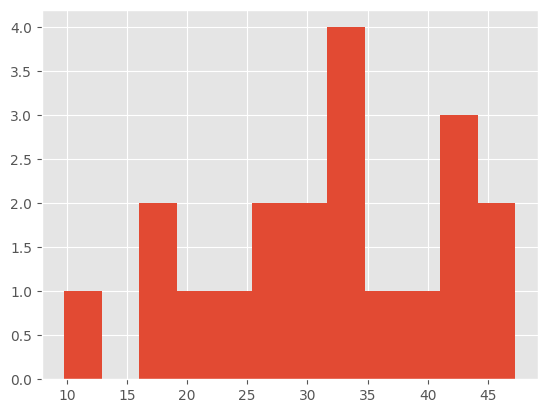

In [24]:
plt.hist(t_list, bins=12)